In [102]:
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import pandas as pd
from PIL import Image

In [103]:
import yaml

with open("config/config.yaml", "r") as file:
    cf = yaml.safe_load(file)

x_train_path = cf['dataset']['x_train']
x_valid_path = cf['dataset']['x_valid']
x_test_path = cf['dataset']['x_test']

y_train_path = cf['dataset']['y_train']
y_valid_path = cf['dataset']['y_valid']
y_test_path = cf['dataset']['y_test']

lr = cf['parameter']['lr']
epoch = cf['parameter']['epoch']
batch_size = cf['parameter']['batch_size']
dropout_rate = cf['parameter']['dropout_rate']

In [104]:
def read_csv(path):
    f_name = os.path.basename(path)
    df = pd.read_csv(path)
    df_len, df_class = df.shape[0], df.shape[1]-1
    print(f"{f_name} have {df_len} rows and {df_class} classes.")

    return df

y_train_df = read_csv(y_train_path)
y_valid_df = read_csv(y_valid_path)
y_test_df = read_csv(y_test_path)

clss_names = y_train_df.columns.tolist()[1:] # ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'])

print(f"Dataset have {len(clss_names)} classes with labels : {clss_names}")

train_groundtruth.csv have 10015 rows and 7 classes.
valid_groundtruth.csv have 193 rows and 7 classes.
test_groundtruth.csv have 1512 rows and 7 classes.
Dataset have 7 classes with labels : ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']


In [105]:
# Dataloader for training set only, dont worry much
class HAM10KDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.labels = pd.read_csv(csv_path)
        self.img_dir = img_dir 
        self.transform = transform

        self.class_cols = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
        
    def __len__(self):
        return len(self.labels)
     
    def __getitem__(self, idx):
        # get image
        img_name = self.labels.iloc[idx]['image'] + '.jpg'
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        
        # get label
        encode_label = self.labels.iloc[idx][self.class_cols].values
        label = self.class_cols[encode_label.argmax()]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [106]:
train_set = HAM10KDataset(
    csv_path=y_train_path,   # CSV
    img_dir=x_train_path,    # thư mục ảnh
)

valid_set = HAM10KDataset(
    img_dir=x_valid_path,
    csv_path=y_valid_path
)

print(f"Kích thước tập train: {len(train_set)}")
print(f"Kích thước tập valid: {len(valid_set)}")
print(f"Kích thước tập test: {len(os.listdir(x_test_path))}")


Kích thước tập train: 10015
Kích thước tập valid: 193
Kích thước tập test: 1512


# Exploratory Data Analysis (EDA)

Tổng số ảnh trong tập train: 10015


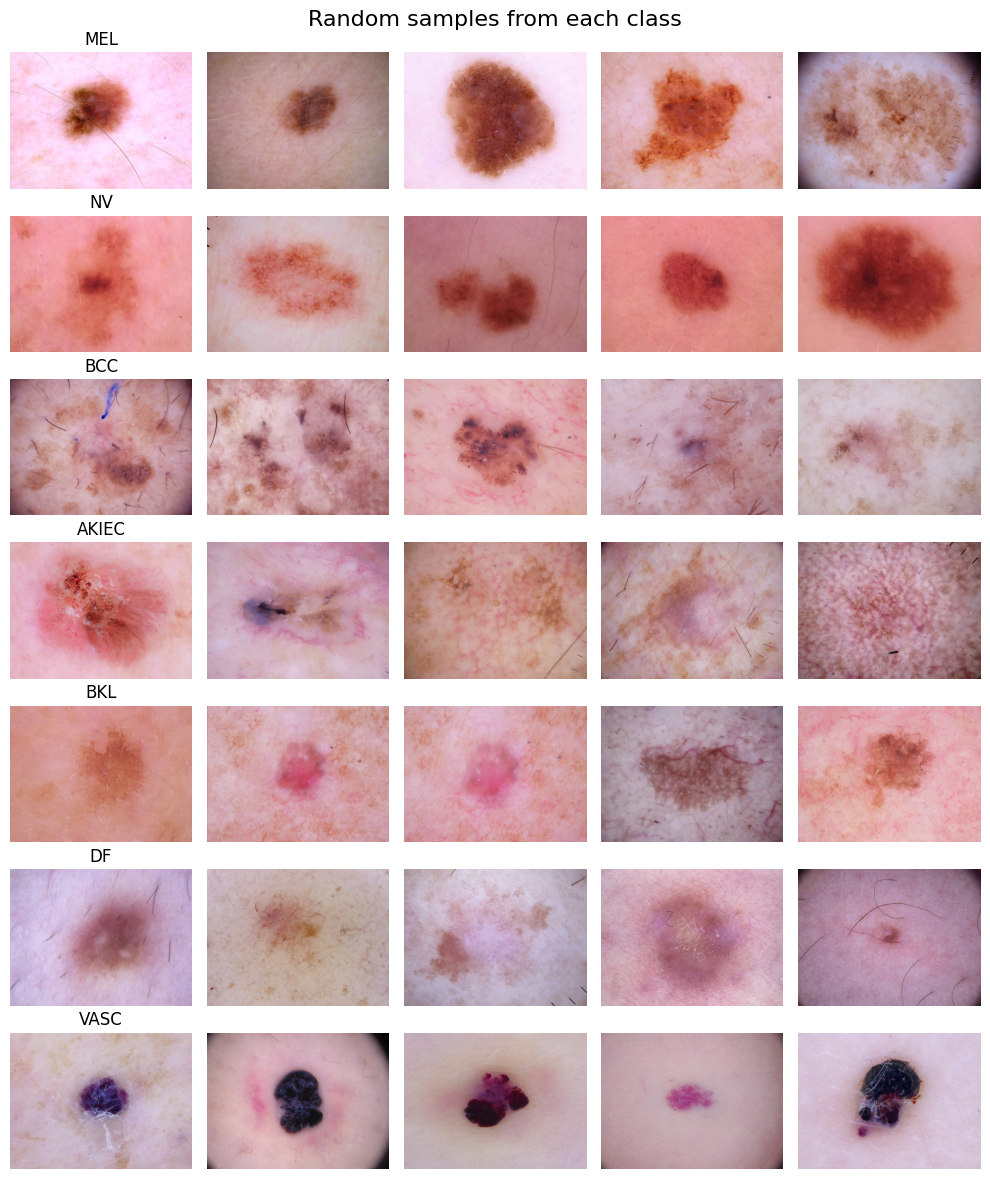

In [107]:
print(f"Tổng số ảnh trong tập train: {len(train_set)}")

def inter_intra_class_visualize(x_train_path, y_train_path, class_names, n=5):
    num_classes = len(class_names)
    y_train_df = pd.read_csv(y_train_path)

    fig, axes = plt.subplots(num_classes, n, figsize=(n*2, num_classes*2-2))

    for row, cls in enumerate(class_names):
        cls_df = y_train_df[y_train_df[cls] == 1]
        samples = cls_df.sample(n)

        for col, img_id in enumerate(samples["image"]):
            img_path = os.path.join(x_train_path, img_id + ".jpg")
            img = Image.open(img_path).convert("RGB")

            axes[row, col].imshow(img)
            axes[row, col].axis("off")

            if col == 0:
                axes[row, col].set_title(cls, fontsize=12)

    plt.suptitle("Random samples from each class", fontsize=16)
    plt.tight_layout()
    plt.show()
    

inter_intra_class_visualize(x_train_path,y_train_path, clss_names, n=5)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6416\329815809.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, clss_counts[i], str(int(clss_counts[i])), ha='center', va='bottom')
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6416\329815809.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, clss_counts[i], str(int(clss_counts[i])), ha='center', va='bottom')


[1113.0, 6705.0, 514.0, 327.0, 1099.0, 115.0, 142.0]
[21.0, 123.0, 15.0, 8.0, 22.0, 1.0, 3.0]


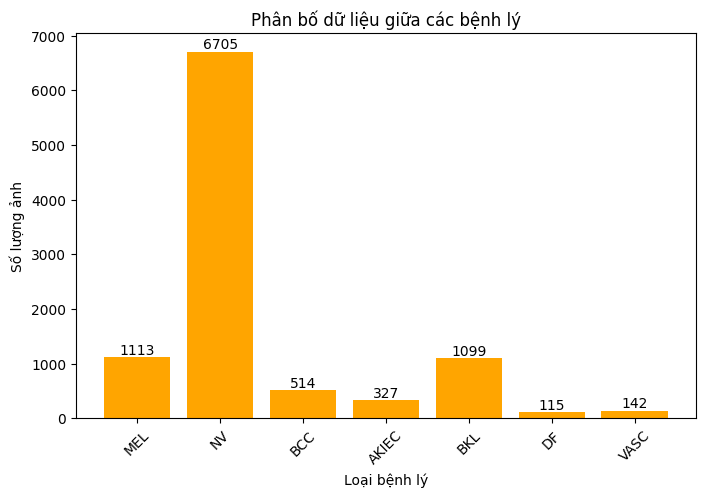

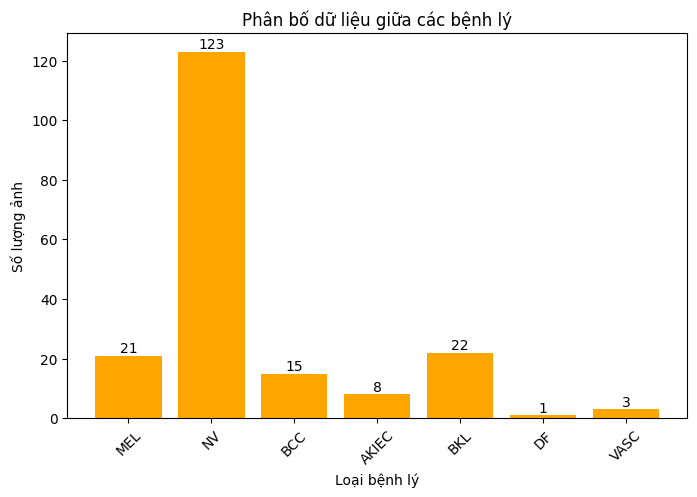

In [108]:
def class_distribution(Dataset):
    df = Dataset.labels
    clss_names = df.columns.tolist()[1:] # ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'])
    clss_counts = df[clss_names].sum() # tổng ca mỗi bệnh lý

    plt.figure(figsize=(8,5))
    plt.bar(clss_names, clss_counts, color='orange')
    plt.xlabel("Loại bệnh lý")
    plt.title(f"Phân bố dữ liệu giữa các bệnh lý")
    plt.ylabel("Số lượng ảnh")
    plt.xticks(rotation=45)

    for i in range(len(clss_names)):
        plt.text(i, clss_counts[i], str(int(clss_counts[i])), ha='center', va='bottom')

    print(clss_counts.tolist())

class_distribution(train_set)
class_distribution(valid_set)

# Kết luận :
Dataset bị mất cân bằng dữ liệu rất lớn giữa các lớp.

Cần tăng cường dữ liệu để giảm bias của mô hình học trên tập dữ liệu này
